# Two batches

In [0]:
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg
from scipy.linalg import expm
import copy

def commutator(A1, A2):
    return A1 @ A2 - A2 @ A1

def log_norm(A):
    w,v = np.linalg.eig((A + A.T)/2)
    mu = np.round(max(w), 14)
    return max(w) 

def sheng_upper_bound(t, A1, A2):
    mu1 = log_norm(A1)
    mu2 = log_norm(A2)
    return t**2/2 * np.linalg.norm(commutator(A1, A2), ord=2)*np.exp((mu1 + mu2)*t)

def true_error(t, A1, A2):
    return np.linalg.norm(expm((A1 + A2)*t) - expm(A1*t) @ expm(A2*t), ord=2)

def generate_problem(p, n):
    X = np.random.randn(n, p)

    # Model definition
    theta_clean = np.ones(p)
    y = X @ theta_clean + 5e-1*np.random.randn(n) # right-hand side
    theta_0 = np.random.randn(p)

    return X, theta_0, y

def plot_errors(errors_list, label_list, t):
    for errors, label in zip(errors_list, label_list):
        plt.semilogy(t, errors, label=label)
    
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('Norm of the error')
    plt.savefig('norms.svg')
    plt.show()

def plot_calculated_constant(X1, X2):
    Q1, R1 = np.linalg.qr(X1.T)
    Q2, R2 = np.linalg.qr(X2.T)
    p, b = Q1.shape
    return np.linalg.norm((np.eye(p) - Q1@Q1.T)@(np.eye(p) - Q2@Q2.T), ord=2)


In [0]:
p = 100
n = 100
N = 2
b = 50

X, theta_0, y = generate_problem(p,n)

Xs = np.zeros((N, b, p))
ys = np.zeros((N, b))

for i_batch in range(N):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :] 
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]

A1 = -1/n*Xs[0].T @ Xs[0]
A2 = -1/n*Xs[1].T @ Xs[1]

In [0]:
ts = np.linspace(0,15)
sheng_errors = [sheng_upper_bound(t, A1, A2) for t in ts]
true_errors  = [true_error(t, A1, A2)        for t in ts]
constant     = plot_calculated_constant(Xs[0], Xs[1])
constants    = [constant                     for t in ts]

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


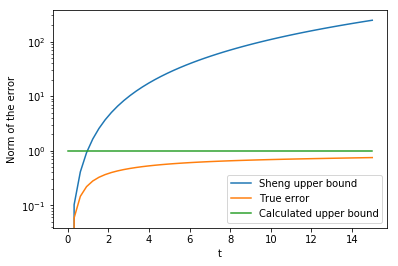

In [88]:
plot_errors([sheng_errors, true_errors, constants], ['Sheng upper bound', 'True error', 'Calculated upper bound'], ts)

# Many batches

In [0]:
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg
from scipy.linalg import expm
import copy
from random import shuffle
from tqdm import tqdm


def true_error(t, As):
    # placeholder for the summand matrix and approximate solution
    A               = np.zeros(As[0].shape)
    approximation   = np.eye(len(As[0]))
    for A_i in As:
        A               += A_i
        approximation   = approximation @ expm(A_i*t)
    true_solution = expm(A*t)
    return np.linalg.norm(true_solution - approximation, ord=2)

def generate_problem(p,n,s):
    X = np.random.randn(n, p)

    # Model definition
    theta_clean = np.ones(p)
    y = X @ theta_clean + 5e-1*np.random.randn(n) # right-hand side
    theta_0 = np.random.randn(p)

    b = int(n // s)
    Xs = np.zeros((s, b, p))
    ys = np.zeros((s, b))

    As = []
    for i_batch in range(s):
        Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :] 
        ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
        As.append(-1/n*Xs[i_batch].T @ Xs[i_batch])

    return As, Xs

def plot_errors(errors_list, label_list, t, title=''):
    for errors, label in zip(errors_list, label_list):
        plt.semilogy(t, errors, label=label)
    
    plt.title(title)
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('Norm of the error')
    plt.savefig('norms.svg')
    plt.show()

def plot_calculated_constant(Xs):
    b, p = Xs[0].shape
    error_product = np.eye(p)
    for X_i in Xs:
        Q_i, R_i = np.linalg.qr(X_i.T)
        projector_i = (np.eye(p) - Q_i@Q_i.T)
        error_product = error_product @ projector_i
  
    return np.linalg.norm(error_product, ord=2)

In [0]:
p = 200
n = 200
s = 40

As, Xs = generate_problem(p,n,s)

ts = np.linspace(0,20)
true_errors  = [true_error(t, As)   for t in ts]
constant     = plot_calculated_constant(Xs)
constants    = [constant            for t in ts]

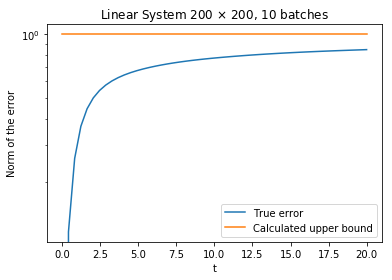

In [186]:
plot_errors([true_errors, constants], ['True error', 'Calculated upper bound'], ts, title=r'Linear System {} $\times$ {}, {} batches'.format(n,p,s))

In [116]:
len(As)

2

In [194]:
constants = []
for i in tqdm(range(1000)):
    perm = permute(len(Xs))
    constants.append(plot_calculated_constant(Xs[perm]))

100%|██████████| 1000/1000 [01:01<00:00, 16.45it/s]


In [195]:
(max(constants) - min(constants))/min(constants)

1.8472395725407192e-06